In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,RepeatVector,TimeDistributed,Bidirectional
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError

In [2]:
# I used Google Chrome whilst working in Google Colab so I was able to complete this step by recieving the authorisation code after logging into my gmail account.
# Users may need to also use Google Chrome to run this code and connect via the browser to your gmail when prompted.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [5]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [6]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [7]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [8]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [9]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [10]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [11]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [12]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [13]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [14]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Split dataset into training and testing datasets

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I no longer need to create a validation set as model selection is complete 
#### 74.15% of the data will be used for training and the remaining 25.85% will be used as the test set

In [16]:
split = int(len(df)*0.7415)

training_set = df[:split]      # 17/8/2017 - 28/6/2020
test_set = df[split:]          # 29/6/2020 - 28/6/2021

In [17]:
print('Training: ', training_set.shape, '\nTest: ', test_set.shape)

Training:  (1046, 5) 
Test:  (366, 5)


# Split the data into X and y variables

In [18]:
# the x values will contain all the features in the dataset and the y value will contain only the target feature to predict (Close Price) 

X_training = (training_set.iloc[:, :]).values.reshape(training_set.shape[0],training_set.shape[1])
y_training = (training_set.iloc[:, 4]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_testing = (test_set.iloc[:, :]).values.reshape(test_set.shape[0],test_set.shape[1])
y_testing = (test_set.iloc[:, 4]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)

(1046, 5) (1046, 1)
(366, 5) (366, 1)


# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [19]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [20]:
# stack the data horizontally

train_stacked = np.hstack((X_train, y_train))
print ("Stacked Training Data Shape: " , train_stacked.shape)

test_stacked = np.hstack((X_test, y_test))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (1046, 6)
Stacked Test Data Shape:  (366, 6)


In [21]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [22]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 7

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (1027, 14, 5) y train sequences (1027, 7)
X test sequences:  (347, 14, 5) y test sequences (347, 7)


# **1. Model Building on CoLab for Multi-Step LSTM model (labelled in the code as Model A)**


### Part 1
#### I will first load the optimised model.

In [23]:
baseline_model_a = load_model('/content/drive/My Drive/Different Inputs/LSTM_Model_A')
baseline_model_a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 80)            27520     
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 80)            51520     
_________________________________________________________________
dropout (Dropout)            (None, 14, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 567       
Total params: 131,127
Trainable params: 131,127
Non-trainable params: 0
__________________________________________________

#### I will train and test the baseline model 5 times to get a list of RMSE scores to use later for statistical comparison. I will report the average test score here.
https://github.com/yanghaocsg/keras_lstm/wiki/chapter-7.1-Evaluating-LSTM-Models-Robustly


Training Number  0


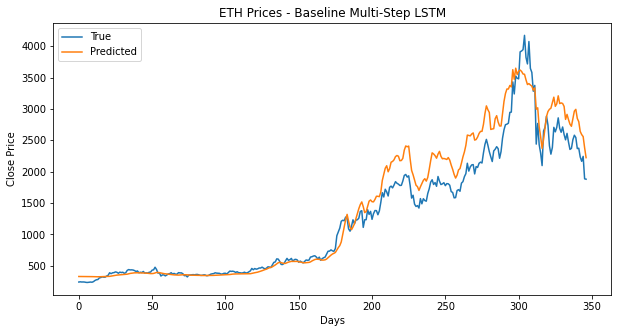


Testing Loss:  0.00604  ||  Testing RMSE:  0.0777  ||  Testing MAE:  0.052

Training Number  1


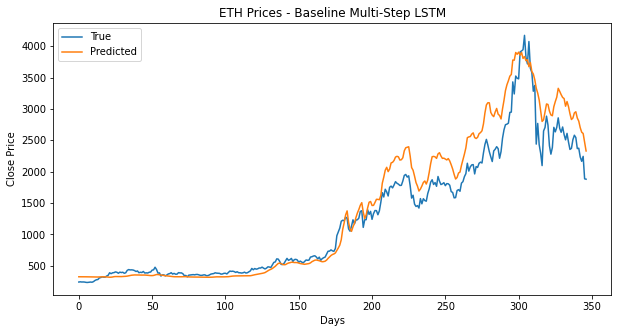


Testing Loss:  0.00581  ||  Testing RMSE:  0.0763  ||  Testing MAE:  0.0522

Training Number  2


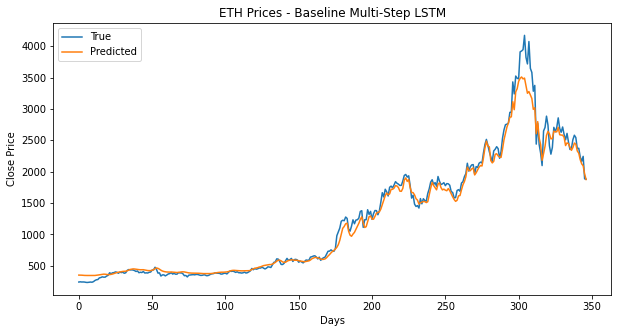


Testing Loss:  0.00244  ||  Testing RMSE:  0.0494  ||  Testing MAE:  0.0301

Training Number  3


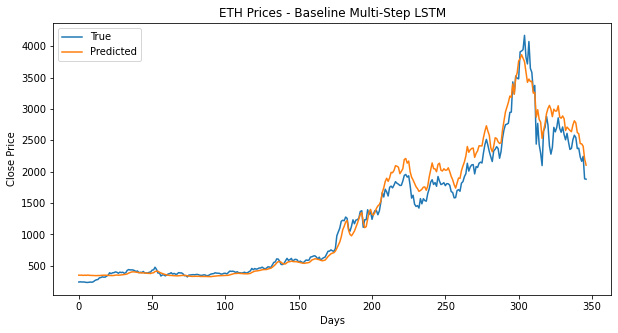


Testing Loss:  0.00291  ||  Testing RMSE:  0.054  ||  Testing MAE:  0.0358

Training Number  4


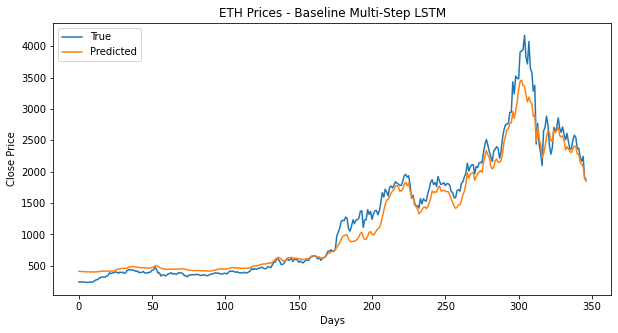


Testing Loss:  0.00492  ||  Testing RMSE:  0.0702  ||  Testing MAE:  0.0463

Baseline Multi-Step LSTM Model -- 
Average Test Loss:  0.00443  ||  Average Test RMSE:  0.0655  ||  Average Test MAE:  0.0433


In [24]:
y_test_inv = yscaler.inverse_transform(y_test)

losslist_a = []
rmselist_a = []
maelist_a = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  baseline_model_a.fit(X_train , y_train , epochs=61 , verbose=0 ,shuffle=False)         # best epoch for this model according to the optimisation results is 61

  # generate the test predictions and plot them against the true values

  test_pred_a = baseline_model_a.predict(X_test)
  test_pred_a = yscaler.inverse_transform(test_pred_a)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_inv[:,0], label = 'True')
  plt.plot(test_pred_a[:,0], label = 'Predicted')
  plt.legend()
  plt.title('ETH Prices - Baseline Multi-Step LSTM')
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_a, test_rmse_a, test_mae_a = baseline_model_a.evaluate(X_test, y_test, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_a), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_a), ' ||  Testing MAE: ', float('%.3g' % test_mae_a))

  losslist_a.append(test_loss_a)
  rmselist_a.append(test_rmse_a)
  maelist_a.append(test_mae_a)

print('\nBaseline Multi-Step LSTM Model -- \nAverage Test Loss: ', float('%.3g' % np.mean(losslist_a)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(rmselist_a)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(maelist_a)))


In [25]:
# saving the RMSE scores of the model to compare against the models with different inputs in a statistical test

baselineScores_a = pd.DataFrame(rmselist_a)
baselineScores_a.to_csv('/content/drive/My Drive/Different Inputs/baselineScores_a.csv', index=False)

# **2. Model Building on CoLab for Encoder-Decoder LSTM model (labelled in the code as Model B)**

### Part 1
#### I will first load the optimised model.


In [26]:
baseline_model_b = load_model('/content/drive/My Drive/Different Inputs/EncoderDecoder_LSTM_Model_B')
baseline_model_b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90)                34560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 90)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 90)             65160     
_________________________________________________________________
dropout (Dropout)            (None, 7, 90)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 90)             65160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 90)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 90)             6

#### I will train and test the baseline model 5 times to get a list of RMSE scores to use later for statistical comparison. I will report the average test score here.




Training Number  0


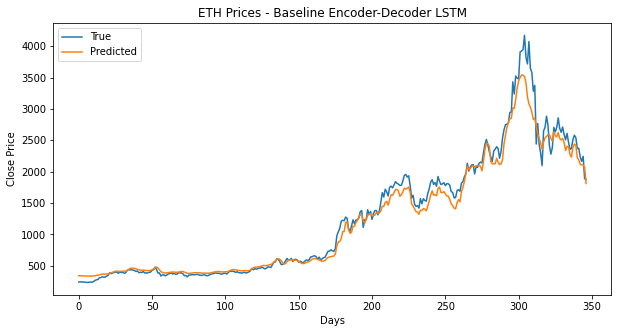


Testing Loss:  0.00297  ||  Testing RMSE:  0.0545  ||  Testing MAE:  0.0332

Training Number  1


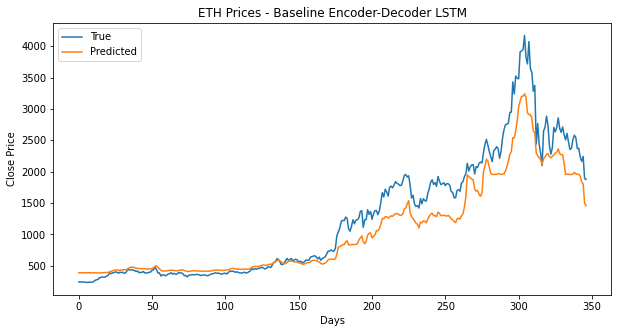


Testing Loss:  0.00797  ||  Testing RMSE:  0.0893  ||  Testing MAE:  0.0622

Training Number  2


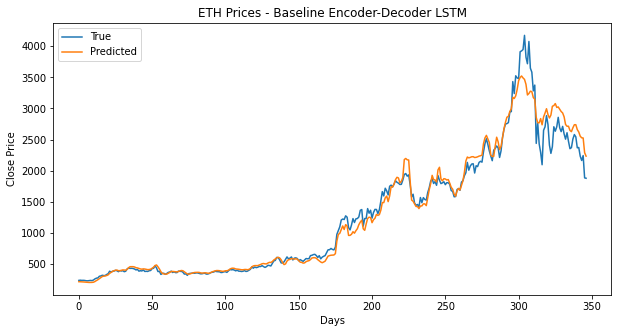


Testing Loss:  0.00309  ||  Testing RMSE:  0.0556  ||  Testing MAE:  0.0355

Training Number  3


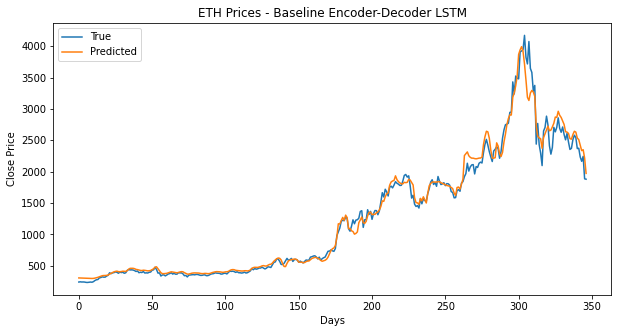


Testing Loss:  0.0033  ||  Testing RMSE:  0.0574  ||  Testing MAE:  0.0329

Training Number  4


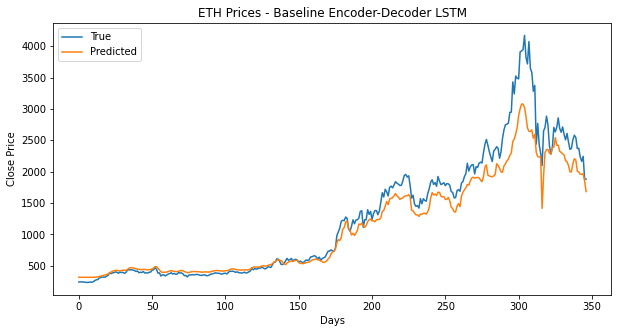


Testing Loss:  0.00736  ||  Testing RMSE:  0.0858  ||  Testing MAE:  0.0497

Baseline Encoder-Decoder LSTM Model -- 
Average Test Loss:  0.00494  ||  Average Test RMSE:  0.0685  ||  Average Test MAE:  0.0427


In [27]:
losslist_b = []
rmselist_b = []
maelist_b = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)

  # for encoder-decoder model, reshape output (y-values) into [samples, timesteps, features]
  y_train_ed = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
  y_test_ed = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

  baseline_model_b.fit(X_train , y_train_ed , epochs=98 , verbose=0 ,shuffle=False)         # best epoch for this model according to the optimisation results is 98

  # generate the test predictions and plot them against the true values

  test_pred_b = baseline_model_b.predict(X_test)
  test_pred_b = test_pred_b.reshape((test_pred_b.shape[0], test_pred_b.shape[1]*test_pred_b.shape[2]))
  test_pred_b = yscaler.inverse_transform(test_pred_b)

  y_test_reshape = y_test_ed.reshape((y_test_ed.shape[0], y_test_ed.shape[1]*y_test_ed.shape[2]))
  y_test_reshape_inv = yscaler.inverse_transform(y_test_reshape)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_reshape_inv[:,0], label = 'True')
  plt.plot(test_pred_b[:,0], label = 'Predicted')
  plt.legend()
  plt.title('ETH Prices - Baseline Encoder-Decoder LSTM')
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_b, test_rmse_b, test_mae_b = baseline_model_b.evaluate(X_test, y_test_ed, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_b), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_b), ' ||  Testing MAE: ', float('%.3g' % test_mae_b))

  losslist_b.append(test_loss_b)
  rmselist_b.append(test_rmse_b)
  maelist_b.append(test_mae_b)

print('\nBaseline Encoder-Decoder LSTM Model -- \nAverage Test Loss: ', float('%.3g' % np.mean(losslist_b)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(rmselist_b)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(maelist_b)))


In [28]:
# saving the RMSE scores of the model to compare against the models with different inputs in a statistical test

baselineScores_b = pd.DataFrame(rmselist_b)
baselineScores_b.to_csv('/content/drive/My Drive/Different Inputs/baselineScores_b.csv', index=False)

# **3. Model Building on CoLab for Bidirectional LSTM model (labelled in the code as Model C)**

### Part 1
#### I will first load the optimised model.


In [29]:
baseline_model_c = load_model('/content/drive/My Drive/Different Inputs/BiLSTM_Model_C')
baseline_model_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 60)            31680     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 60)            58080     
_________________________________________________________________
dropout (Dropout)            (None, 14, 60)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14, 60)            58080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 60)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60)                58080     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0

#### I will train and test the baseline model 5 times to get a list of RMSE scores to use later for statistical comparison. I will report the average test score here.


Training Number  0


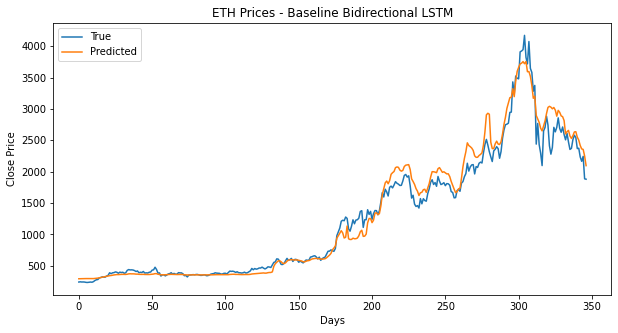


Testing Loss:  0.00342  ||  Testing RMSE:  0.0585  ||  Testing MAE:  0.0384

Training Number  1


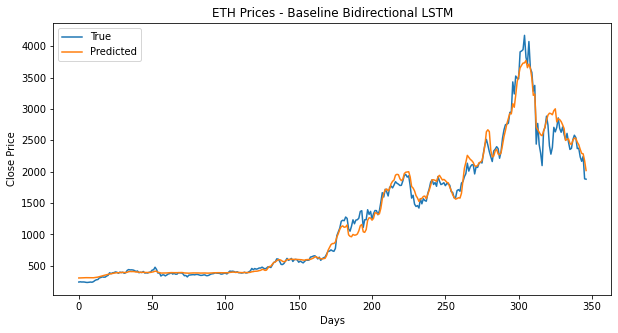


Testing Loss:  0.00274  ||  Testing RMSE:  0.0524  ||  Testing MAE:  0.0314

Training Number  2


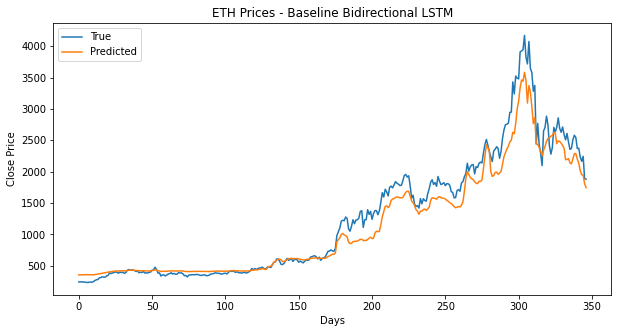


Testing Loss:  0.00521  ||  Testing RMSE:  0.0722  ||  Testing MAE:  0.0474

Training Number  3


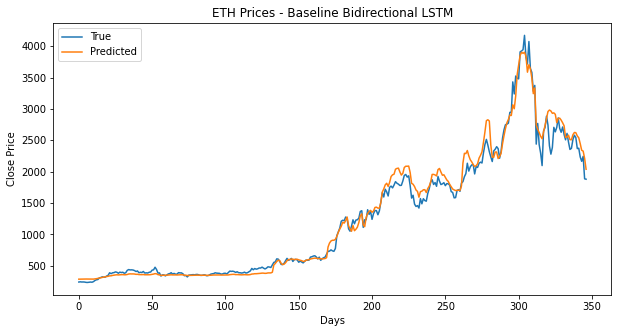


Testing Loss:  0.00365  ||  Testing RMSE:  0.0604  ||  Testing MAE:  0.0359

Training Number  4


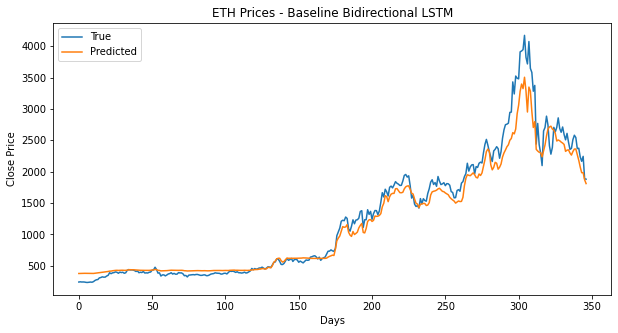


Testing Loss:  0.00421  ||  Testing RMSE:  0.0649  ||  Testing MAE:  0.0401

Baseline Bidirectional LSTM Model -- 
Average Test Loss:  0.00385  ||  Average Test RMSE:  0.0617  ||  Average Test MAE:  0.0386


In [32]:
losslist_c = []
rmselist_c = []
maelist_c = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  baseline_model_c.fit(X_train , y_train , epochs=67 , verbose=0 ,shuffle=False)         # best epoch for this model according to the optimisation results is 67

  # generate the test predictions and plot them against the true values

  test_pred_c = baseline_model_c.predict(X_test)
  test_pred_c = yscaler.inverse_transform(test_pred_c)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_inv[:,0], label = 'True')
  plt.plot(test_pred_c[:,0], label = 'Predicted')
  plt.legend()
  plt.title('ETH Prices - Baseline Bidirectional LSTM')
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_c, test_rmse_c, test_mae_c = baseline_model_c.evaluate(X_test, y_test, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_c), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_c), ' ||  Testing MAE: ', float('%.3g' % test_mae_c))

  losslist_c.append(test_loss_c)
  rmselist_c.append(test_rmse_c)
  maelist_c.append(test_mae_c)

print('\nBaseline Bidirectional LSTM Model -- \nAverage Test Loss: ', float('%.3g' % np.mean(losslist_c)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(rmselist_c)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(maelist_c)))


In [33]:
# saving the RMSE scores of the model to compare against the models with different inputs in a statistical test

baselineScores_c = pd.DataFrame(rmselist_c)
baselineScores_c.to_csv('/content/drive/My Drive/Different Inputs/baselineScores_c.csv', index=False)